### EE6310: Image and Video Processing

#### Import Libraries

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import colormaps

#### 1. The Human Eye
In this problem you will implement the contrast sensitivity function (CSF) based living room design.
Write a Python script that accepts the TV specifications (size, resolution), the available distance for
the couch placement (from the TV), and outputs the “optimal” distance. Recall from class that this
distance corresponds to 6 cycles/degree being intended at the visual axis. Assume that the couch is
placed directly in front of the TV. You are expected to handle corner cases gracefully.

In [75]:
def CSF(tv_size, tv_resolution, dist_available):

    pixel_length = tv_size / np.sqrt(tv_resolution[0] ** 2 + tv_resolution[1] ** 2)

    optimal_dist = (6 * pixel_length)/(np.tan(np.pi/360))
    return min(dist_available, optimal_dist)

In [76]:
tv_size = 55 # generally when TV size is given, the diagonal length is given
tv_resolution = (1920, 1020)
dist_available = 20

CSF(tv_size, tv_resolution, dist_available)

17.39289719072791

#### 2. Gray Scale Images

i) Read the contents of an image into an array I (recall from class that digital images are represented
as an array of numbers). Use matplotlib to read and display images - https://matplotlib.org/tutorials/introductory/images.html. Display the image I

In [77]:
def read_image(path):
    image = plt.imread(path)
    return image

def display_image(image, size = 4):
    aspect_ratio = image.shape[1]/image.shape[0]

    plt.figure(figsize=(size*aspect_ratio, size))
    plt.imshow(image, cmap='gray')
    plt.show()

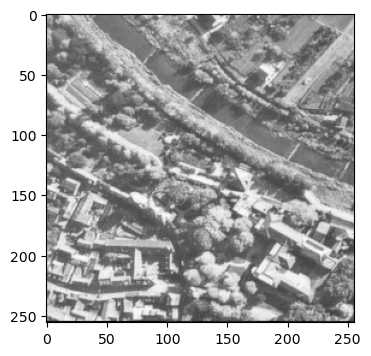

In [78]:
path = 'misc/5.1.10.tiff'
image = read_image(path)
display_image(image)

ii) Print the maximum and minimum pixel values of I. Based on these values, how many bits are needed
(used) per pixel? What is the resolution (i.e., width and height) of I? Print your answer.

In [79]:
max_value = np.amax(image)
min_value = np.amin(image)

print("Maximum Value: ", max_value)
print("Minimum Value: ", min_value)

print("Number of bits needed:", np.ceil(np.log2(max_value - min_value)))

width = image.shape[1]
height = image.shape[0]

print(f"Height = {height}, Width = {width}" )

Maximum Value:  248
Minimum Value:  1
Number of bits needed: 8.0
Height = 256, Width = 256


iii) What is the size of the compressed image you downloaded? Print your answer. Based on the previous
answers and assuming 256 gray levels, how efficienctly (compressed image size versus 8 bits per pixel
size) is the image compressed for storage? Print your answer.

In [80]:
print("Image size:", os.path.getsize(path) / 1024, "kB")

print("Image Size without compression:", (height * width) / 1024, "kB")

Image size: 64.130859375 kB
Image Size without compression: 64.0 kB


This could be due to the fact that the image stores other information like the headers and so on. Thus, the actual image size is greater than the compressed value.

iv) Write a function that accepts as input an image I and a bitplane index i.e., a number b such that
0 ≤ b ≤ B − 1. The function must display the bitplane b of the image I as a binary image. Use the
convention that b = 0 corresponds to the least significant bitplane and b = B − 1 corresponds to the
most significant bitplane.

In [81]:
def bitplane(image, b):
    bitplane_image = (image // 2**(b)) % 2
    display_image(bitplane_image, size = 3)

Bitplane:  7


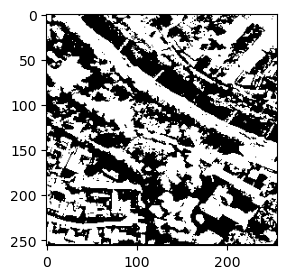

Bitplane:  6


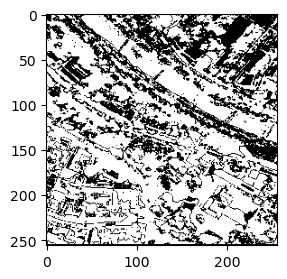

Bitplane:  5


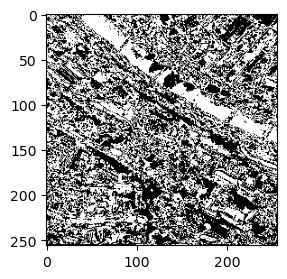

Bitplane:  4


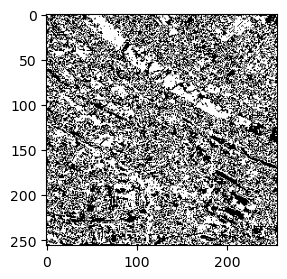

Bitplane:  3


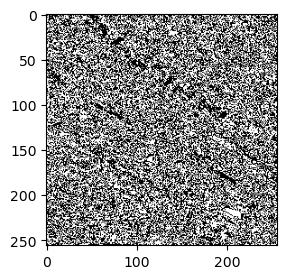

Bitplane:  2


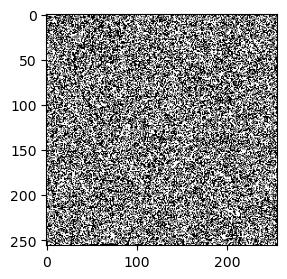

Bitplane:  1


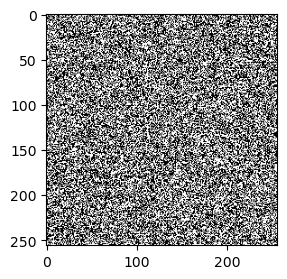

Bitplane:  0


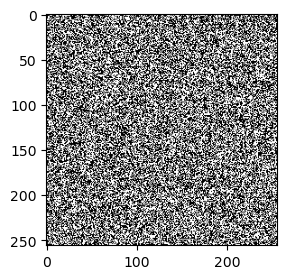

In [82]:
for i in range(7, -1, -1):
    print("Bitplane: ", i)
    bitplane(image, i)

#### 3. Binary Image Processing

For this part, work with the gray scale images aerial, airplane, APC.

i) Write a function to compute the histogram of an image and plot the same. What is the modality of the
histogram for the images mentioned above?

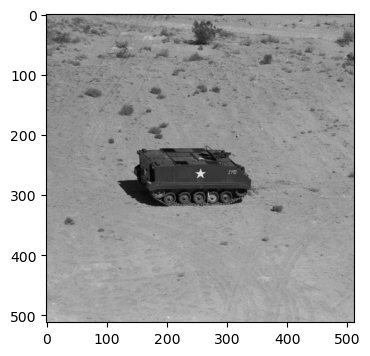

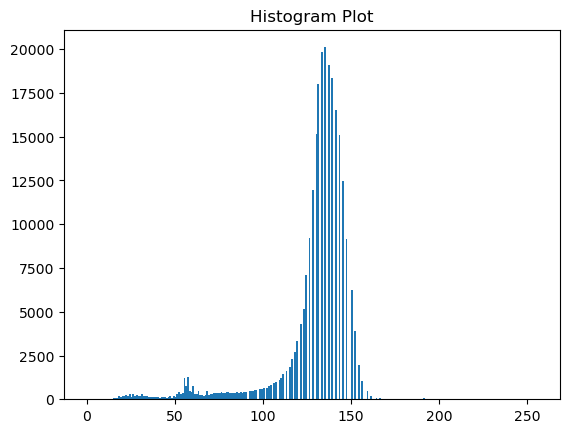

In [83]:
apc_path = 'misc/7.1.08.tiff' #You can replace this path with anything to see the results for that image
image_read = read_image(apc_path)
display_image(image_read)

histogram= np.zeros(256)

for i in range (image_read.shape[0]):
    for j in range (image_read.shape[1]):
        histogram[image_read[i][j]] += 1

plt.stairs(histogram, fill= True)
plt.title("Histogram Plot")
plt.show()

In a unimodal function, the pixel intensities will be clustered around a single value. In a bi-modal function, the pixel intensities will be clustered around 2 separate values.
In the above function, the intensities is clustered around a single value. Thus, it is unimodal.

ii) Binarize I using the above histogram following the modal thresholding approach discussed in class.

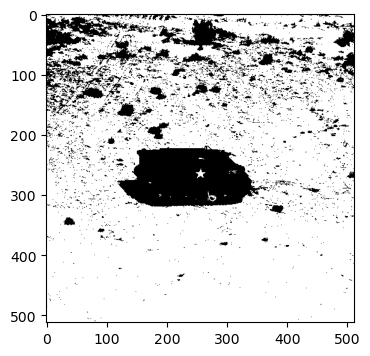

In [84]:
def binarize_image(image, threshold = 128):
    binarized_image = np.zeros(image.shape)

    for i in range (image.shape[0]):
        for j in range (image.shape[1]):
            if (image[i][j] > threshold):
                binarized_image[i][j] = 1
            else:
                binarized_image[i][j] = 0
    return binarized_image

threshold = 120 #this works for apc image

# We take the threshold such that there are almost equal number of pixels in both the halves. 
# This is one way of ensuring that the information obtained is maximum

binarized_image = binarize_image(image_read, threshold)
display_image(binarized_image)


iii) Implement Otsu’s algorithm in two ways.

(a) Construct the weighted intra-class variance array $σ^{2}_{w}(t) = P_0(t)σ^2_0(t) + P_1(t)σ^2_1(t)$ where t is the threshold, $P_0(t) = ∑_i p(i)$ is the probability of gray level 0, $P_1(t) = 1 − P_0(t)$ is the probability of gray level 1, $σ^2_0(t)$ is the variance of the pixels assigned to gray level 0, $σ^2_1(t)$ is the variance of
the pixels assigned to gray level 1. Note that p(t) corresponds to the probability that the image
intensity is t (i.e., the normalized histogram or the probability mass function). Sweep over all
possible values of t and pick the threshold where $σ^2_w(t)$ takes its minimum value.

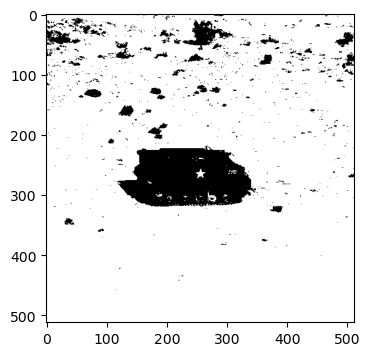

Threshold = 99


In [85]:
def otsu_binarization_1(image):
    total_pixels = image.shape[0] * image.shape[1]

    frequencies = np.zeros(256)
    
    for i in range (image.shape[0]):
        for j in range (image.shape[1]):
            frequencies[int(image[i][j])] += 1

    probabilities = frequencies/total_pixels

    best_sigma_w = 320000
    best_t = 128

    for t in range(256):
        P_0 = np.sum(probabilities[0 : t + 1])
        P_1 = 1 - P_0

        if (P_0 == 0 or P_0 == 1):
            continue

        #calculating M_0, M_1
        M_0 = 0
        M_1 = 0
        for i in range (t + 1):
            M_0 += i * probabilities[i]/P_0
        
        for i in range (t + 1, 256):
            M_1 += i * probabilities[i]/P_1
        
        #calculating variance
        sigma_0 = 0
        sigma_1 = 0

        for i in range(t + 1):
            sigma_0 += ((i - M_0)**2)*probabilities[i]/P_0
        
        for i in range(t + 1, 256):
            sigma_1 += ((i - M_1)**2)*probabilities[i]/P_1
        
        sigma_w = P_0*sigma_0 + P_1*sigma_1

        if (sigma_w < best_sigma_w):
            best_sigma_w = sigma_w
            best_t = t
    return best_t

ostu_threshold = otsu_binarization_1(image_read)
otsu_binarized_image = binarize_image(image_read, ostu_threshold)
display_image(otsu_binarized_image)
print("Threshold =", ostu_threshold)

b) A more efficient implementation is based on the observation that the total image variance $σ^2 = σ^2_b(t) + σ^2_w(t)$ where $σ^2, σ^2_b(t), σ^2_w(t)$ are the image variance, between class (or inter-class) variance and the within class (or intra-class variance) respectively. Further, it can be shown that $σ^2_b(t) = P_0(t)(1 − P_0(t))[μ_0(t) − μ_1(t)]^2$ , where $P_0(t), P_1(t)$ are as defined in the previous question, and $μ_0(t), μ_1(t)$ are the means of gray level 0 pixels and gray level 1 pixels respectively. Importantly, the between class variance $σ^2_b(t)$ can be computed recursively as follows. Note that μ is the image mean.

In [86]:
def otsu_binarization_2(image):
    total_pixels = image.shape[0] * image.shape[1]

    frequencies = np.zeros(256)
    
    for i in range (image.shape[0]):
        for j in range (image.shape[1]):
            frequencies[int(image[i][j])] += 1

    probabilities = frequencies/total_pixels

    M = 0
    for i in range (256):
        M += i * probabilities[i]

    P_0 = np.zeros(256)
    M_0 = np.zeros(256)
    M_1 = np.zeros(256)
    sigma_b = np.zeros(256)

    P_0[0] = probabilities[0]
    M_0 [0] = 0

    for t in range(255):
        P_0[t + 1] = P_0[t] + probabilities[t + 1]
        if (P_0[t + 1] == 0 or P_0[t + 1] == 1):
            continue
        M_0[t + 1] = (M_0[t] * P_0[t] + (t + 1)*probabilities[t + 1])/P_0[t + 1]
        M_1[t + 1] = (M - M_0[t + 1]*P_0[t + 1])/(1 - P_0[t + 1])

        sigma_b[t + 1] = P_0[t + 1] * (1 - P_0[t + 1]) * ((M_0[t + 1] - M_1[t + 1]) ** 2)
    
    return np.argmax(sigma_b)

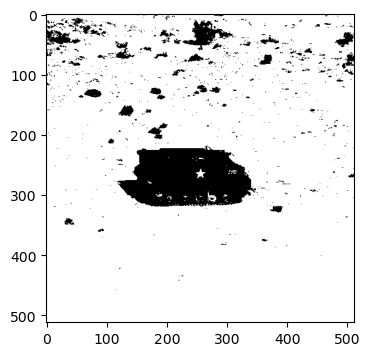

Threshold = 99


In [87]:
ostu_threshold = otsu_binarization_2(image_read)
otsu_binarized_image = binarize_image(image_read, ostu_threshold)
display_image(otsu_binarized_image)
print("Threshold =", ostu_threshold)

iv) Implement the connected components algorithm and use it to label the binarized version of I. Demonstrate your result using any of the gray scale images mentioned above.

Number of blobs: 896


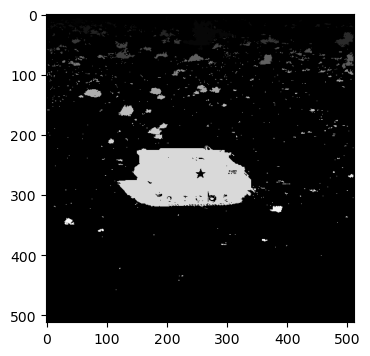

In [88]:
def findParent(array, element):
    if (array[element] == element):
        return element
    else:
        return findParent(array, array[element])

def connected_components(image):
    ostu_threshold = otsu_binarization_2(image)
    otsu_binarized_image = binarize_image(image, ostu_threshold)

    R = np.zeros(otsu_binarized_image.shape, dtype = np.uint32)
    region_counter = 1
    regions = [0, 1]

    #Assumption: Border pixels are background and have the same value 0

    for i in range (1, otsu_binarized_image.shape[0] - 1):
        for j in range(1, otsu_binarized_image.shape[1] - 1):
            if (otsu_binarized_image[i][j] == 0):
                if (otsu_binarized_image[i][j - 1] == 1 and otsu_binarized_image[i - 1][j] == 1):
                    R[i][j] = region_counter
                    region_counter += 1
                    regions.append(region_counter)
                elif (otsu_binarized_image[i][j - 1] == 1 and otsu_binarized_image[i - 1][j] == 0):
                    R[i][j] = R[i - 1][j]
                elif (otsu_binarized_image[i][j - 1] == 0 and otsu_binarized_image[i - 1][j] == 1):
                    R[i][j] = R[i][j - 1]
                else:
                    R[i][j] = min(R[i][j - 1], R[i - 1][j])
                    if (R[i][j - 1] != R[i - 1][j]):
                        regions[R[i][j - 1]] = findParent(regions, min(R[i][j - 1], R[i - 1][j]))
                        regions[R[i - 1][j]] = findParent(regions, min(R[i][j - 1], R[i - 1][j]))
    temp = []
    for i in range(len(regions)):
        if (regions[i] != i):
            temp.append(i)
            regions[i] = findParent(regions, regions[i])

    # for i in range(len(temp)):
    #     if temp[i] in regions:
    #         print(temp[i])

    for i in range (1, otsu_binarized_image.shape[0] - 1):
        for j in range(1, otsu_binarized_image.shape[1] - 1):
            R[i][j] = regions[int(R[i][j])]

    return R, np.unique(R).shape[0] - 1

R, regions = connected_components(image_read)
print("Number of blobs:", regions)
display_image(R)

v) Implement minor blob removal to get rid of minor blobs. Demonstrate your result using the gray
scale image you used in the previous question.

In [89]:
def complement(image):
    new_image = np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] == 0:
                new_image[i][j] = 1
            else:
                new_image[i][j] = 0
    return new_image

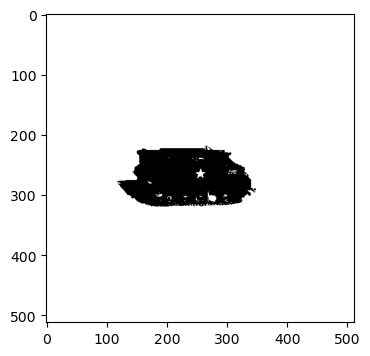

In [90]:
def minor_blob_removal(image):

    R, regions = connected_components(image)
    frequencies = np.zeros(np.max(R) + 1)

    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if (R[i][j] != 0):
                frequencies[R[i][j]] += 1
    
    max_freq = np.argmax(frequencies)

    for i in range(np.max(R) + 1):
        if (frequencies[i] < frequencies[max_freq]):
            frequencies[i] = 0
    
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if (frequencies[R[i][j]] == 0):
                R[i][j] = 0
            else:
                R[i][j] = 1
    return R

display_image(complement(minor_blob_removal(image_read)))


#### 4 Binary Morphology

i) Implement the following filters that accept a binary image I and window B as inputs: DILATE,
ERODE, MEDIAN. Filter the above binary image using the following windows B = CROSS(5), B =
SQUARE(3) (meaning the side of the square window is 3 pixels). Use the binary images generated in
the previous question as input to this function.

In [91]:
# Cross 5:
B1 = {(0, 1), (1, 0), (2, 0), (0, 2), (0, -1), (-1, 0), (0, -2), (-2, 0)}

# Square 3:
B2 = {(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)}

Original Image: 


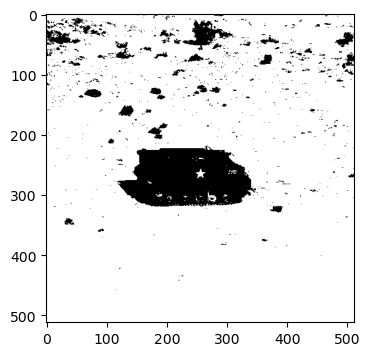

After dilation with B1: 


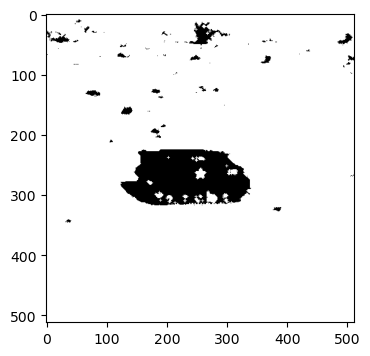

After dilation with B2: 


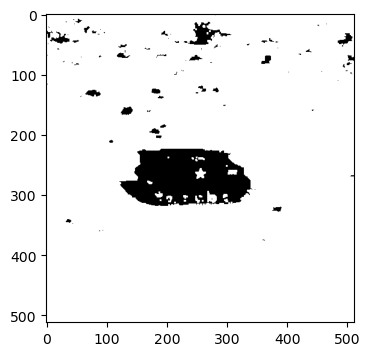

In [92]:
def dilate(binary_image, B):
    new_image = np.zeros(binary_image.shape)
    for i in range(binary_image.shape[0]):
        for j in range(binary_image.shape[1]):

            output = int(binary_image[i][j])
            for coordinate in B:
                x = i + coordinate[0]
                y = j + coordinate[1]

                if (x < 0 or y < 0 or x >= binary_image.shape[0] or y >= binary_image.shape[1]):
                    new_coordinate = np.zeros(2)
                    if (x < 0):
                        new_coordinate[0] = -coordinate[0] - 1
                    elif (x >= binary_image.shape[0]):
                        new_coordinate[0] = -coordinate[0] + 1
                    if (y < 0):
                        new_coordinate[1] = -coordinate[1] - 1
                    elif (y >= binary_image.shape[1]):
                        new_coordinate[1] = -coordinate[1] + 1
                    x = i + new_coordinate[0]
                    y = j + new_coordinate[1]

                output = output | int(binary_image[int(x)][int(y)])

            new_image[i][j] = output
    return new_image

print("Original Image: ")
display_image(otsu_binarized_image)
print("After dilation with B1: ")
display_image(dilate(otsu_binarized_image, B1))
print("After dilation with B2: ")
display_image(dilate(otsu_binarized_image, B2))


In [93]:
def erode(binary_image, B):
    new_image = np.zeros(binary_image.shape)
    for i in range(binary_image.shape[0]):
        for j in range(binary_image.shape[1]):

            output = int(binary_image[i][j])
            for coordinate in B:
                x = i + coordinate[0]
                y = j + coordinate[1]

                if (x < 0 or y < 0 or x >= binary_image.shape[0] or y >= binary_image.shape[1]):
                    new_coordinate = np.zeros(2)
                    if (x < 0):
                        new_coordinate[0] = -coordinate[0] - 1
                    elif (x >= binary_image.shape[0]):
                        new_coordinate[0] = -coordinate[0] + 1
                    if (y < 0):
                        new_coordinate[1] = -coordinate[1] - 1
                    elif (y >= binary_image.shape[1]):
                        new_coordinate[1] = -coordinate[1] + 1
                    x = i + new_coordinate[0]
                    y = j + new_coordinate[1]

                output = output & int(binary_image[int(x)][int(y)])

            new_image[i][j] = output
    return new_image

Original Image: 


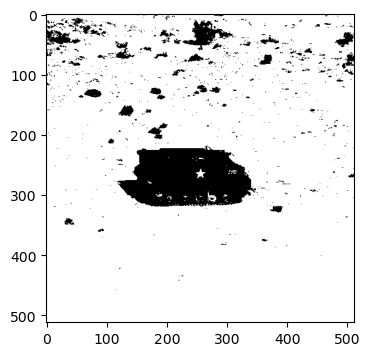

After erosion with B1: 


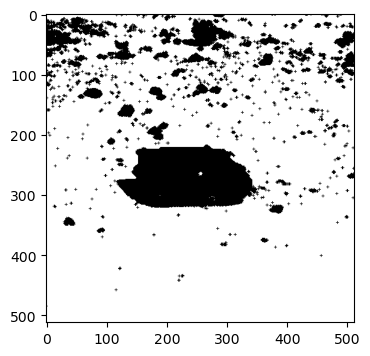

After erosion with B2: 


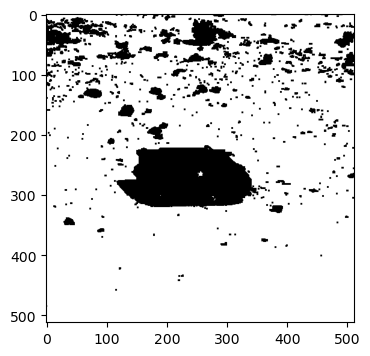

In [94]:
print("Original Image: ")
display_image(otsu_binarized_image)
print("After erosion with B1: ")
display_image(erode(otsu_binarized_image, B1))
print("After erosion with B2: ")
display_image(erode(otsu_binarized_image, B2))

In [95]:
def median(binary_image, B):
    new_image = np.zeros(binary_image.shape)
    for i in range(binary_image.shape[0]):
        for j in range(binary_image.shape[1]):
            
            output = np.zeros(len(B) + 1)
            output [len(B)] = int(binary_image[i][j])
            for num, coordinate in enumerate(B):
                x = i + coordinate[0]
                y = j + coordinate[1]

                if (x < 0 or y < 0 or x >= binary_image.shape[0] or y >= binary_image.shape[1]):
                    new_coordinate = np.zeros(2)
                    if (x < 0):
                        new_coordinate[0] = -coordinate[0] - 1
                    elif (x >= binary_image.shape[0]):
                        new_coordinate[0] = -coordinate[0] + 1
                    if (y < 0):
                        new_coordinate[1] = -coordinate[1] - 1
                    elif (y >= binary_image.shape[1]):
                        new_coordinate[1] = -coordinate[1] + 1
                    x = i + new_coordinate[0]
                    y = j + new_coordinate[1]

                output[num] = (int(binary_image[int(x)][int(y)]))
            if (np.sum(output) <= 4):
                new_image [i][j] = 0
            else:
                new_image[i][j] = 1
    return new_image

Original Image: 


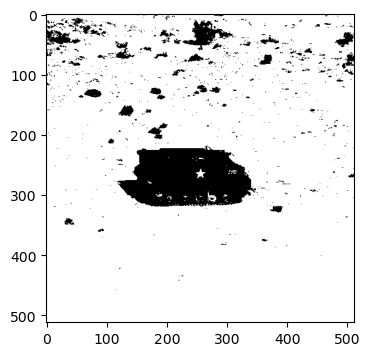

After median with B1: 


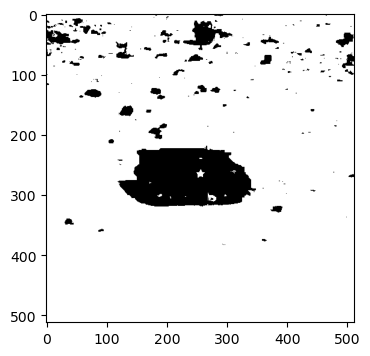

After median with B2: 


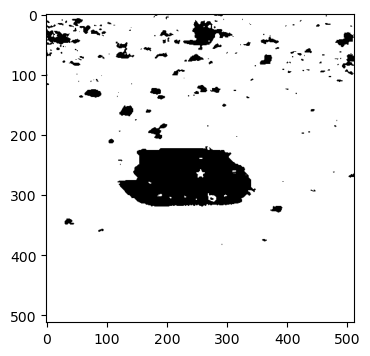

In [96]:
print("Original Image: ")
display_image(otsu_binarized_image)
print("After median with B1: ")
display_image(median(otsu_binarized_image, B1))
print("After median with B2: ")
display_image(median(otsu_binarized_image, B2))

ii) Verify that DILATE and ERODE operators are duals of each other with respect to complementation.
Also verify that the MEDIAN operator is its own dual with respect to complementation. Show that
the difference between the images from the direct and complement paths is indeed zero.

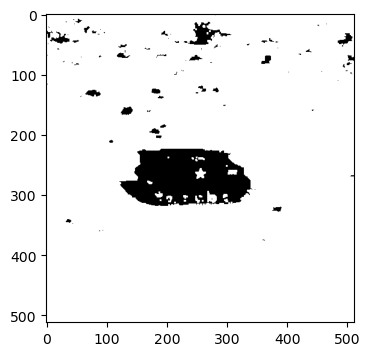

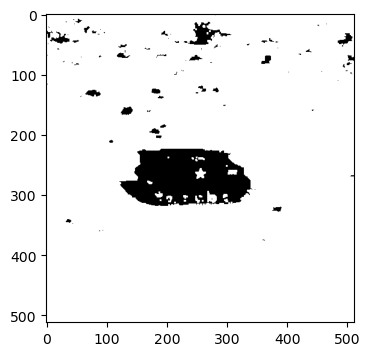

Both the images are same. Thus, dilation and erosion are duals of each other with respect to complementation


In [97]:
#dilation and erosion are complements of each other:

dilated_image = dilate(otsu_binarized_image, B2)
eroded_complemented_image = complement(erode(complement(otsu_binarized_image), B2))

display_image(dilated_image)
display_image(eroded_complemented_image)

temp = True

for i in range(dilated_image.shape[0]):
    for j in range(dilated_image.shape[1]):
        if dilated_image [i][j] != eroded_complemented_image[i][j]:
            temp = False
if (temp):
    print("Both the images are same. Thus, dilation and erosion are duals of each other with respect to complementation")
else:
    print("Dilation and erosion are not complements of each other")

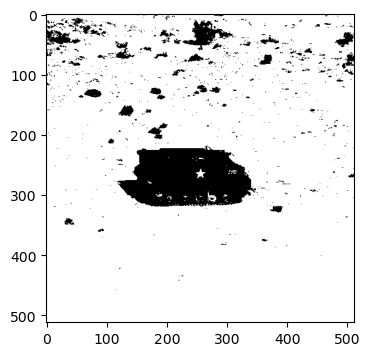

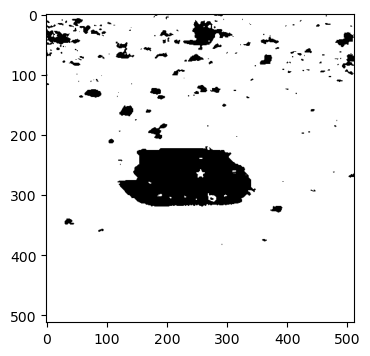

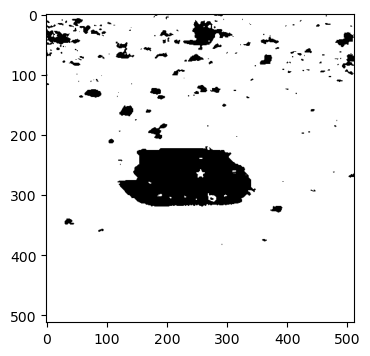

Both the images are same. Thus, median is its own dual with respect to complementation


In [98]:
#median is its own dual wrt complement:

median_1 = median(otsu_binarized_image, B2)
median_complement = complement(median(complement(otsu_binarized_image), B2))

display_image(otsu_binarized_image)
display_image(median_1)
display_image(median_complement)

temp = True

for i in range(median_1.shape[0]):
    for j in range(median_1.shape[1]):
        if median_1 [i][j] != median_complement[i][j]:
            temp = False
if (temp):
    print("Both the images are same. Thus, median is its own dual with respect to complementation")
else:
    print("Median is not its own dual")

iii) Implement the compound operators OPEN and CLOSE using the basic filters implemented above.
Use the same windows as in the previous problem.

In [99]:
def OPEN(binary_image, B):
    return dilate(erode(binary_image, B), B)

def CLOSE(binary_image, B):
    return erode(dilate(binary_image, B), B)

Original Image: 


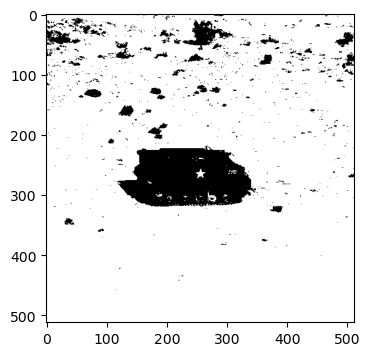

After OPEN with B1: 


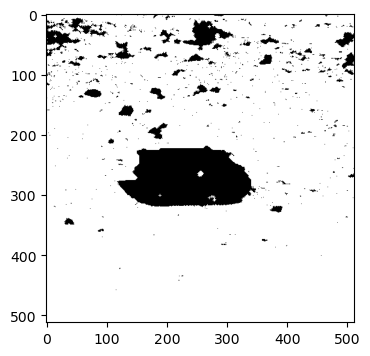

After OPEN with B2: 


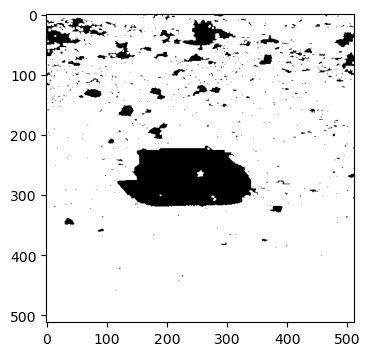

In [100]:
print("Original Image: ")
display_image(otsu_binarized_image)
print("After OPEN with B1: ")
display_image(OPEN(otsu_binarized_image, B1))
print("After OPEN with B2: ")
display_image(OPEN(otsu_binarized_image, B2))

Original Image: 


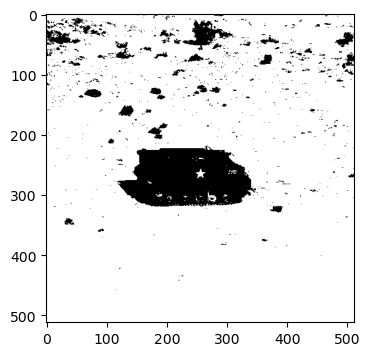

After CLOSE with B1: 


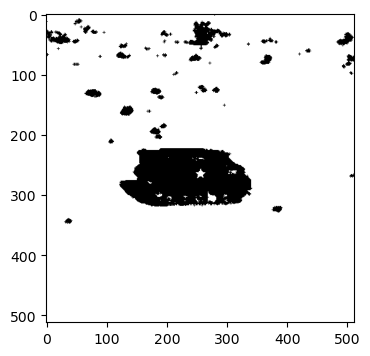

After CLOSE with B2: 


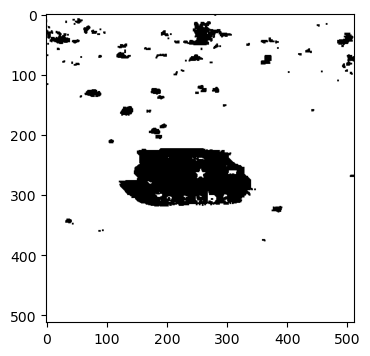

In [101]:
print("Original Image: ")
display_image(otsu_binarized_image)
print("After CLOSE with B1: ")
display_image(CLOSE(otsu_binarized_image, B1))
print("After CLOSE with B2: ")
display_image(CLOSE(otsu_binarized_image, B2))

iv) Finally, implement OPEN-CLOS and CLOS-OPEN. Filter the binary image using the same windows
as above.

In [102]:
def OPEN_CLOS(binary_image, B):
    return OPEN(CLOSE(binary_image, B), B)

def CLOS_OPEN(binary_image, B):
    return CLOSE(OPEN(binary_image, B), B)

Original Image: 


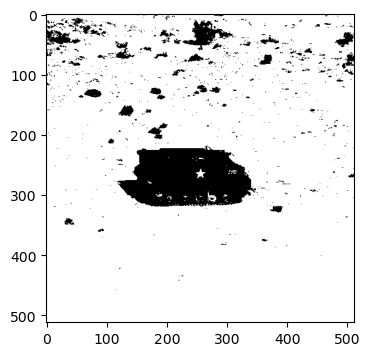

After OPEN_CLOS with B1: 


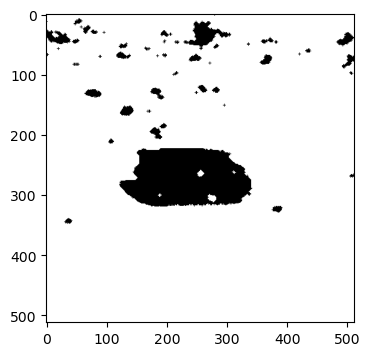

After OPEN_CLOS with B2: 


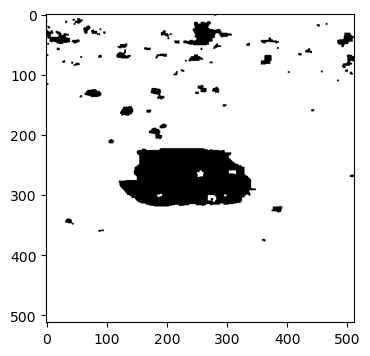

Original Image: 


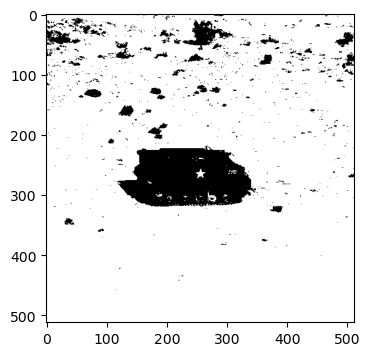

After CLOS_OPEN with B1: 


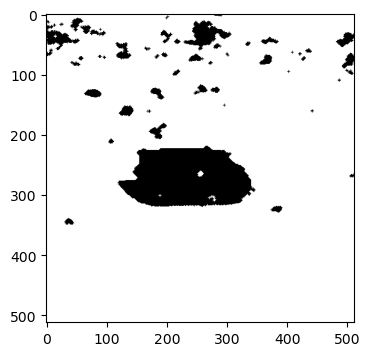

After CLOS_OPEN with B2: 


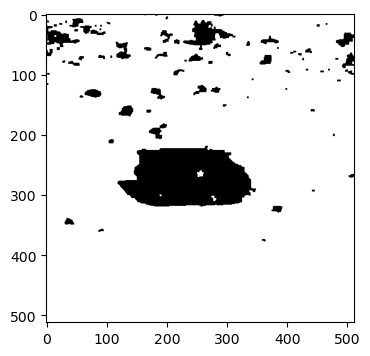

In [103]:
print("Original Image: ")
display_image(otsu_binarized_image)
print("After OPEN_CLOS with B1: ")
display_image(OPEN_CLOS(otsu_binarized_image, B1))
print("After OPEN_CLOS with B2: ")
display_image(OPEN_CLOS(otsu_binarized_image, B2))

print("Original Image: ")
display_image(otsu_binarized_image)
print("After CLOS_OPEN with B1: ")
display_image(CLOS_OPEN(otsu_binarized_image, B1))
print("After CLOS_OPEN with B2: ")
display_image(CLOS_OPEN(otsu_binarized_image, B2))

v) For the APC image, count the number of pixels in the object of interest - i.e., the military vehicle. Use
the blob counting code from the previous problem.

Pixels in the tank: 17109.0
Image after thresholding and minor blob removal:


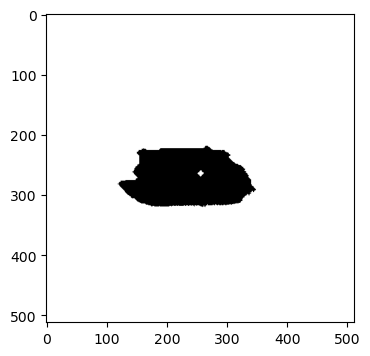

In [104]:
APC_image = read_image('misc/7.1.08.tiff')
binarized_image = binarize_image(APC_image, otsu_binarization_2(APC_image))

#applying clos-open
B3 = {(0, 1), (1, 0), (2, 0), (0, 2), (0, -1), (-1, 0), (0, -2), (-2, 0), (3, 0), (0, 3), (-3, 0), (0, -3), (1, 1), (1, -1), (-1, 1), ((-1, -1))}
binarized_image = CLOS_OPEN(binarized_image, B3)
binarized_image = complement(minor_blob_removal(binarized_image))

for i in range(binarized_image.shape[0]):
    for j in range(binarized_image.shape[1]):
        binarized_image[i][j] = int(binarized_image[i][j])

print("Pixels in the tank:", np.sum(complement(binarized_image)))

print("Image after thresholding and minor blob removal:")
display_image(binarized_image)